<a href="https://colab.research.google.com/github/JairEsc/Aproximaciones-de-Modelos-Epidemiologicos/blob/main/EBCM_NM_simulaciones.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import newton
import networkx as nx

In [39]:
def Funciones_dado_metodo(u,method='',params=[],densities=[],survivals=[],aristas_en_riesgo=[],vertices_infecciosos=[]):
  if method=='general' or method=='aproximado':
    psi_infection,psi_recovery=densities
    psi_survival_infection,psi_survival_recovery=survivals
    def f_to_solve_general(x):
      S_1=np.sum([np.log(psi_survival_infection(x+r)) for r in aristas_en_riesgo['tiempo']])
      S_2=np.sum([np.log(psi_survival_recovery(x+r)) for r in vertices_infecciosos['tiempo']])
      S_3=np.sum([np.log(psi_survival_infection(r)) for r in aristas_en_riesgo['tiempo']])
      S_4=np.sum([np.log(psi_survival_recovery(r)) for r in vertices_infecciosos['tiempo']])
      return (S_1+S_2-S_3-S_4-np.log(u))
    def f_to_solve_general_prime(x):
      S_1=np.sum([(psi_infection(x+r)/psi_survival_infection(x+r)) for r in aristas_en_riesgo['tiempo']])
      S_2=np.sum([(psi_recovery(x+r)/psi_survival_recovery(x+r)) for r in vertices_infecciosos['tiempo']])
      return (-S_1-S_2)
    return 0,0,0,0,f_to_solve_general,f_to_solve_general_prime
  if method=='Weibull':
    a_I,a_R,lammbda_I,lammbda_R=params
    def f_to_solve(x):
      S_1=np.sum([(x+r)**(a_I) for r in aristas_en_riesgo['tiempo']])
      S_2=np.sum([(x+r)**(a_R) for r in vertices_infecciosos['tiempo']])
      S_3=np.sum([r**a_I for r in aristas_en_riesgo['tiempo']])
      S_4=np.sum([r**a_R for r in vertices_infecciosos['tiempo']])
      return ((lammbda_I**(a_I))*(S_1-S_3)+(lammbda_R**(a_R))*(S_2-S_4)+np.log(u))
    def f_to_solve_prime(x):
      S_1=a_I*np.sum([(x+r)**(a_I-1) for r in aristas_en_riesgo['tiempo']])
      S_2=a_R*np.sum([(x+r)**(a_R-1) for r in vertices_infecciosos['tiempo']])
      return (a_I*(lammbda_I**(a_I))*S_1+a_R*(lammbda_R**(a_R))*S_2)
    return  a_I,a_R,lammbda_I,lammbda_R,f_to_solve,f_to_solve_prime
def Gillespie_Direct_Method_Non_markovian_network(N,X_I_indexes,method='',params=[],densities=[],survivals=[],G_network_initial=nx.Graph(),T=np.inf,tuto=False):
  #Recibe: method:
    #'general': Dando las densidades y supervivencias
    #'aproximado': Dando las densidades y supervivencias
    #'Weibull': Dando un vector de parámetros con $a_I,a_R,lammbda_I,lammbda_R"
  #Recibe: G_newtwork_initial la gráfica generada con Networkx
  #Recibe: X_I_indexes, un vector de indices de los nodos incicialmente infecciosos (al tiempo t=0)

  #--------------------------------------
  #Paso 0
  t=0
  X_I=len(X_I_indexes)
  X_S=N-X_I
  X_R=0
  Historia=[[0,X_S,X_I]]
  #Definir aristas_en_riesgo:
  aristas_en_riesgo={'arista':[],'tiempo':[]}
  vertices_infecciosos={'vertice':[],'tiempo':[]}
  #Llenar estos arreglos.
  #N es el número de individuos.
  for j in X_I_indexes:
    vertices_infecciosos['vertice'].append(j)
    vertices_infecciosos['tiempo'].append(0)
    for i in range(N):
      if G_network_initial.has_edge(i,j) and i not in X_I_indexes:
        aristas_en_riesgo['arista'].append((min(i,j),max(i,j)))#Los agregamos en un orden específico.
        aristas_en_riesgo['tiempo'].append(0)
  #--------------------------------------
  if(tuto):
    print("Inicia:")
    print("Condiciones iniciales: N=",N,'X_I=',len(X_I_indexes))
    print("aristas_en_riesgo:",aristas_en_riesgo['arista'])
    print("vertices_infecciosos:",vertices_infecciosos['vertice'])
    print("Asi se ve la grafica:n")
    nx.draw(G=G_network_initial,pos=pos,node_color=['green' if G_network_initial.nodes[i]['Estado:']=='Susceptible' else 'red' if G_network_initial.nodes[i]['Estado:']=='Infeccioso' else 'gray' for i in G.nodes()],with_labels=True)
    plt.show()
  #Paso 1
  while(X_I>0 and t<T):
    u=np.random.uniform()
    #Definir la funcion $\Phi$.
    #Depende del metodo y los valores introducidos.
    a_I,a_R,lammbda_I,lammbda_R,f_to_solve,f_to_solve_prime=Funciones_dado_metodo(u=u,method=method,params=params,densities=densities,survivals=survivals,aristas_en_riesgo=aristas_en_riesgo,vertices_infecciosos=vertices_infecciosos)
    #--------------------------------------
    #Paso 2
    tau=0.001
    if method=='aproximado':
      if(len(aristas_en_riesgo['tiempo'])+len(vertices_infecciosos['tiempo'])>=20 ):
        sum=0
        for r in aristas_en_riesgo['tiempo']:
          sum+=psi_infection(r)/psi_survival_infection(r)
        for r in vertices_infecciosos['tiempo']:
          sum+=psi_recovery(r)/psi_survival_recovery(r)
        if(sum>0):
          tau=-np.log(u)/(sum)
      else:
        tau=newton(func=f_to_solve,x0=tau/2,fprime=f_to_solve_prime)
    else:
      tau=newton(func=f_to_solve,x0=tau/2,fprime=f_to_solve_prime)
    #--------------------------------------
    #Paso 3-4
    #Definir las probabilidades de elección de cada canal
    if method=='Weibull':
      pi_s_teoricas=[]
      sum=0
      for j in range(len(aristas_en_riesgo['tiempo'])):
        pi_s_teoricas.append(lammbda_I*a_I*(lammbda_I*(tau+aristas_en_riesgo['tiempo'][j]))**(a_I-1))
      for j in range(len(vertices_infecciosos['tiempo'])):
        pi_s_teoricas.append(lammbda_R*a_R*(lammbda_R*(tau+vertices_infecciosos['tiempo'][j]))**(a_R-1))
      pi_s=pi_s_teoricas/np.sum(pi_s_teoricas)
    else:
      pi_s=[]
      sum=0
      for i in range(len(aristas_en_riesgo['tiempo'])):
        pi_s.append(psi_infection(aristas_en_riesgo['tiempo'][i]+tau)/psi_survival_infection(aristas_en_riesgo['tiempo'][i]+tau))
        sum+=pi_s[-1]
      for i in range(len(vertices_infecciosos['tiempo'])):
        pi_s.append(psi_recovery(vertices_infecciosos['tiempo'][i]+tau)/psi_survival_recovery(vertices_infecciosos['tiempo'][i]+tau))
        sum+=pi_s[-1]
      pi_s=pi_s/sum
    #--------------------------------------
    #Paso 5
    #Decidir el canal de reacción.
    k=np.random.choice(len(pi_s),p=pi_s)
    #--------------------------------------
    #Paso 6
    #Actualizamos los tiempos desde la última reacción de todos los canales.
    #I.e. A todas las aristas en riesgo y todos los vértices infecciosos, se les actualiza $t_j+=t_j+tau$
    #Incluso para la reacción que Sí ocurrió, pues más adelanta la eliminamos.
    aristas_en_riesgo['tiempo']=[tau+x for x in aristas_en_riesgo['tiempo']]
    vertices_infecciosos['tiempo']=[tau+x for x in vertices_infecciosos['tiempo']]
    if k<len(aristas_en_riesgo['tiempo']):
      #Ocurre una infección.
      reaccion='infeccion'
      X_I+=1
      X_S-=1
      arista_elegida=aristas_en_riesgo['arista'][k]#k<len(aristas)
      involucrado_1,involucrado_2=arista_elegida[0],arista_elegida[1]
      #Identificar al nuevo infectado-------------
      if(G_network_initial.nodes[involucrado_1]['Estado:']=='Susceptible'):
      #involucrado_1 es el nuevo infeccioso
        nuevo_infectado=involucrado_1
      else:
        if(G_network_initial.nodes[involucrado_1]['Estado:']=='Infeccioso'):
          nuevo_infectado=involucrado_2
        else:
          print("Algo malo esta ocurriendo")
      G_network_initial.nodes[nuevo_infectado]['Estado:']='Infeccioso'#Actualizacion en el grafo.
      #-------------------------
      #Agregarlo a la lista vertices_infecciosos con tiempo 0----
      vertices_infecciosos['vertice'].append(nuevo_infectado)
      vertices_infecciosos['tiempo'].append(0)
      #-------------------------
      #Agrega a la lista aristas_en_riesgo a aquellas nuevas aristas que podrían provocar una infección, con tiempo 0.
      for nei in G_network_initial.neighbors(nuevo_infectado):
        if(G_network_initial.nodes[nei]['Estado:']=='Susceptible'):
          aristas_en_riesgo['arista'].append((min(nei,nuevo_infectado),max(nei,nuevo_infectado)))
          aristas_en_riesgo['tiempo'].append(0)
        else:
          if(G_network_initial.nodes[nei]['Estado:']=='Infeccioso'):#Arista Infeccioso-Infeccioso, la quitamos.
            index=aristas_en_riesgo['arista'].index((min(nuevo_infectado,nei),max(nuevo_infectado,nei)))
            aristas_en_riesgo['arista'].pop(index)
            aristas_en_riesgo['tiempo'].pop(index)
      nuevo_involucrado=nuevo_infectado
      #-------------------------
    else:
      #Ocurre una recuperación.
      reaccion='recuperacion'
      X_I-=1
      X_R+=1
      indice_respecto_vertices=k-len(aristas_en_riesgo['tiempo'])#k>=len(aristas). I.e. Es vértice
      nuevo_recuperado=vertices_infecciosos['vertice'][indice_respecto_vertices]
      #Actualiza el estado a Recuperado.
      G_network_initial.nodes[nuevo_recuperado]['Estado:']='Recuperado'#Actualizacion en el grafo.
      #-----------------------------
      #Elimina de la lista vertices_infecciosos al nuevo recuperado.
      vertices_infecciosos['vertice'].pop(indice_respecto_vertices)
      vertices_infecciosos['tiempo'].pop(indice_respecto_vertices)
      #-----------------------------
      #Elimina de la lista aristas_en_riesgo a aquellas aristas que involucran al nuevo recuperado.
      aristas_en_riesgo_copia=aristas_en_riesgo['arista'].copy()
      count=-1
      for l in range(len(aristas_en_riesgo_copia)):
        edge=aristas_en_riesgo_copia[l]
        if(edge[0]==nuevo_recuperado or edge[1]==nuevo_recuperado):
          count+=1
          aristas_en_riesgo['arista'].pop(l-count)
          aristas_en_riesgo['tiempo'].pop(l-count)
      nuevo_involucrado=nuevo_recuperado
    t+=tau #Actualiza el tiempo $t=t+\tau$.
    Historia.append([t,X_S,X_I])#Focus
  #Fin del While()
  return pd.DataFrame(Historia,columns=['time','S(t)','I(t)'])

In [40]:
#Generar gráfica Ley de Potencias truncada.
import time
start_time_00=time.time()
N=10**3
I_0=int(0.01*N)
import scipy.stats
s=0
for k in range(3,61):
    s+=k**(-2.5)
s=s**(-1)
deg_sum=1
while(deg_sum==1):
  grados=np.random.choice(np.arange(3,61),size=N,p=[s*k**(-2.5) for k in range(3,61)])
  deg_sum=np.sum(grados)%2
G=nx.configuration_model(grados)
G = nx.Graph(G)#Remover multi-aristas
G.remove_edges_from(nx.selfloop_edges(G))#Remover bucles
pos=nx.spring_layout(G,seed=2,k=3)
X_I_indexes=np.random.choice(N,size=I_0,replace=False).tolist()
for k in range(N):
    if k in X_I_indexes:
        G.nodes[k]['Estado:']='Infeccioso'
    else:
        G.nodes[k]['Estado:']='Susceptible'

In [41]:
def EBCM_non_markovian(iniciales,riesgo_inf,riesgo_rec,fgp,fgp_prime_1,fgp_prime_2,step_len,fin):
  S_0,I_0,R_0,theta_0=iniciales
  z=riesgo_inf
  rho=riesgo_rec
  beta=riesgo_inf(0)
  t,a,k=0,0,0
  T=[0]
  theta=[theta_0]
  phi_t_a=[theta_0-(fgp_prime_1(theta_0))/(fgp_prime_1(1))]
  i_t_a=[I_0]
  I=[I_0]
  h=step_len
  while(t<fin):
    k+=1
    phi_t_a_new=[]
    i_t_a_new=[]
    int_z_phi=np.sum([z(a+i*h)*phi_t_a[i] for i in range(len(phi_t_a))])*h
    theta.append(theta[-1]-int_z_phi)
    phi_t_a_new.append(int_z_phi*fgp_prime_2(theta_0)/fgp_prime_1(1))
    i_t_a_new.append(fgp_prime_1(theta_0)*int_z_phi)
    theta_0=theta[-1]
    for j in range(k):
      phi_t_a_new.append(phi_t_a[j]-(rho(a+h*j)+z(a+h*j))*phi_t_a[j]*h)
      i_t_a_new.append(i_t_a[j]-(rho(a+h*j))*i_t_a[j]*h)
    I.append(np.sum(i_t_a_new))
    phi_t_a=phi_t_a_new
    i_t_a=i_t_a_new
    t+=h
    T.append(t)
  return T,I,theta

251.77264881134033  segundos por iteracion
274.9720616340637  segundos por iteracion
276.3624894618988  segundos por iteracion
271.7806041240692  segundos por iteracion
271.5653030872345  segundos por iteracion
56.830078125  segundos para normal


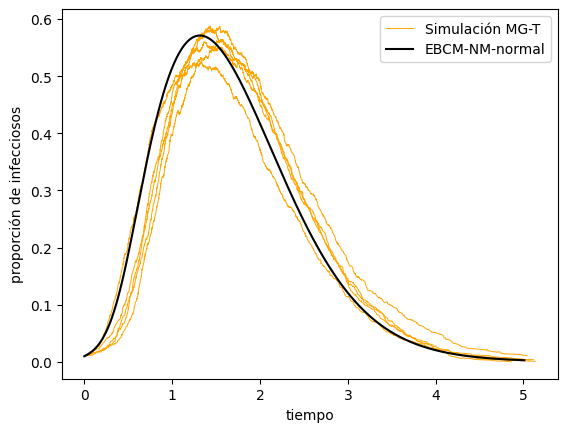

1428.6740126609802  segundos en total


In [42]:
#densidades y supervivencias
#normal----------------------------------
mu=1
sigma=0.75
beta=0.75
np.random.seed(0)
def psi_survival_infection(x):
    return np.exp(-beta*x)
def psi_survival_recovery(x):
    return 1-scipy.stats.norm.cdf(x,loc=1,scale=0.75)
def psi_infection(x):
    return beta*np.exp(-beta*x)
def psi_recovery(x):
    return scipy.stats.norm.pdf(x,loc=mu,scale=sigma)
for k in range(5):
    #------------------------------------ General
    iter_time = time.time()
    G_copy=G.copy()
    X_I_indexes_copy=X_I_indexes.copy()
    H=Gillespie_Direct_Method_Non_markovian_network(N=N,X_I_indexes=X_I_indexes_copy,method='aproximado',params=[],densities=[psi_infection,psi_recovery],survivals=[psi_survival_infection,psi_survival_recovery],G_network_initial=G_copy,T=5)
    if(k==0):
        plt.plot(H['time'],H['I(t)']/N, 'orange',linewidth=0.7,label='Simulación MG-T')
    else:
        plt.plot(H['time'],H['I(t)']/N, 'orange',linewidth=0.7)
    print(time.time()-iter_time,' segundos por iteracion')
#normal Campo Medio------------------------------------
def approx_psi_powerlaw(x):
    u=0
    for k in range(3,61):
        u+=k**(-2.5)*x**k
    return s*u
def approx_prime_psi_powerlaw(x):
    u=0
    for k in range(3,61):
        u+=k**(-1.5)*x**(k-1)
    return s*u
def approx_prime_2_psi_powerlaw(x):
    u=0
    for k in range(3,61):
        u+=(k-1)*k**(-1.5)*x**(k-2)
    return s*u
I_0=0.01
from scipy.optimize import fsolve
def psi_CI_pl(x):
  return approx_psi_powerlaw(x)+I_0-1
theta_0=fsolve(psi_CI_pl,1,)[0]
import matplotlib.pyplot as plt
iniciales=[1-I_0,I_0,0,theta_0]
beta=0.75
gamma=1
fin_T=5
step_len=0.01
def beta_cte(a):
    return beta
def gamma_fun_normal(a):
    with np.errstate(divide='raise'):
      try:
        ret=scipy.stats.norm.pdf(a,loc=1,scale=0.75)/(1-scipy.stats.norm.cdf(a,loc=1,scale=0.75))
      except:
        ret=0.01**(-1)
    return ret
start_time=time.time()
T,I_normal,TH=EBCM_non_markovian(iniciales=iniciales,riesgo_inf=beta_cte,riesgo_rec=gamma_fun_normal,fgp=approx_psi_powerlaw,
                       fgp_prime_1=approx_prime_psi_powerlaw,fgp_prime_2=approx_prime_2_psi_powerlaw,step_len=step_len,fin=fin_T)
print(time.time()-start_time," segundos para normal")
plt.ylabel('proporción de infecciosos')
plt.xlabel('tiempo')
plt.plot(T,I_normal,'black',label='EBCM-NM-normal')
####
plt.legend()
plt.savefig("EBCN_NM_sim_Normal.png",dpi=300)
plt.show()
print(time.time()-start_time_00," segundos en total")

In [43]:
def Monte_Carlo_Step_exp(Lambdas,dict_num_contacts,X_I_indexes):
    Lambda=np.sum(Lambdas)
    tau=np.random.exponential(scale=1/Lambda)
    u_2=np.random.uniform(0,1)
    if(u_2<(Lambda-Lambdas[-1])/Lambda):#Infeccion
        u_3=np.random.uniform(0,1)
        D=0
        k=0
        while(u_3>D):
            D+=Lambdas[k]/(Lambda-Lambdas[-1])
            k+=1
        new_reaction_index=np.random.choice(range(len(dict_num_contacts[str(k-1)])))
        new_reaction=dict_num_contacts[str(k-1)][new_reaction_index]
    else:#Recuperación
        k=0
        new_reaction_index=np.random.choice(range(len(X_I_indexes)))
        new_reaction=X_I_indexes[new_reaction_index]
    return tau,new_reaction,k-1,new_reaction_index
def Gillespie_Direct_Method_Network(beta,gamma,N,X_I_indexes,G_network_initial=nx.Graph(),T=np.inf):
    flag=True
    #Paso 1.
    t=0 #Inicializar $t=0$.
    #Calcular $k_i$ el número de contactos infecciosos del individuo $i$.--------------------
    X_I=len(X_I_indexes)
    X_S=N-X_I
    Historia=[[0,X_S,X_I]]
    dict_num_contacts = {}
    for n in range(X_I+1):
        dict_num_contacts[str(n)]=[]
    num_cont_inf_por_indice=np.zeros(N)
    for i in range(N):
        if(i not in X_I_indexes): #No es infeccioso.
            count_for_i=0
            for j in X_I_indexes:
                if (G_network_initial.has_edge(i,j)):#Es un contacto Susceptible-infeccioso.
                    num_cont_inf_por_indice[i]+=1#Ya que voy a hacer los ciclos, mejor la guardo igual.
                    count_for_i+=1
            dict_num_contacts[str(count_for_i)].append(i)
    #-------------------------------------------
    while(flag):
        #Generar las Lambdas------------------
        Lambda=0
        Lambdas=[]
        for k in range(len(list(dict_num_contacts.keys()))):
            Lambdas.append((beta/N)*len(dict_num_contacts[str(k)])*k)#
            Lambda+=Lambdas[-1]
        Lambdas.append(gamma*X_I)
        Lambda+=Lambdas[-1]
        #-------------------------------------------
        #Paso Monte-Carlo---------------------------
        tau,new_reaction,k_choice,new_reaction_index=Monte_Carlo_Step_exp(Lambdas,dict_num_contacts,X_I_indexes)
        #-------------------------------------------
        #Actualización del sistema.
        if(G_network_initial.nodes[new_reaction]['Estado:']=='Susceptible'):#Se trata de una infección
            num_cont_inf_por_indice[new_reaction]=0
            G_network_initial.nodes[new_reaction]['Estado:']='Infeccioso'#Actualizar su estado
            X_I_indexes.append(new_reaction)
            i=new_reaction
            dict_num_contacts[str(k_choice)].pop(new_reaction_index)#Saca al nuevo infeccioso del conjunto con exactamente k_choice contactos infecciosos.
            #Para cada nodo $j$ conectado a $i$, actualizamos su número de contactos infecciosos como $k_j=k_j+1.$--------------------
            num_max_cont=int(list(dict_num_contacts.keys())[-1])
            for vecino in G_network_initial.neighbors(i):#Para cada vecino del nuevo infectado, le aumentamos el numero de contactos en 1. (lo agregamos a la siguiente categoria y lo sacamos de la anterior)
                if (G_network_initial.nodes[vecino]['Estado:']=='Susceptible'):

                    num_cont_del_vecino=num_cont_inf_por_indice[vecino]
                    if(num_cont_del_vecino+1>num_max_cont):#Si mas de uno crea una categoria, hay error.
                        num_max_cont+=1
                        dict_num_contacts[str(int(num_cont_del_vecino+1))]=[vecino]
                    else:
                        dict_num_contacts[str(int(num_cont_del_vecino+1))].append(vecino)
                    dict_num_contacts[str(int(num_cont_del_vecino))].remove(vecino)
                    num_cont_inf_por_indice[vecino]+=1#Actualizamos ambas fuentes de informacion
            #-------------------------------------------
        else:
            G_network_initial.nodes[new_reaction]['Estado:']='Recuperado'
            num_cont_inf_por_indice[new_reaction]=0#Ya no es relevante
            X_I_indexes.pop(new_reaction_index)
            i=new_reaction
            #Para cada nodo $j$ conectado a $i^* $, actualizamos su número de contactos infecciosos como $k_j=k_j-1.$
            for vecino in G_network_initial.neighbors(i):#Podria ser que ya no tuviera ningun contacto
                num_cont_del_vecino=num_cont_inf_por_indice[vecino]
                if(num_cont_del_vecino!=0):# Es recuperado.
                    dict_num_contacts[str(int(num_cont_del_vecino-1))].append(vecino)
                    dict_num_contacts[str(int(num_cont_del_vecino))].remove(vecino)
                    num_cont_inf_por_indice[vecino]-=1#Actualizamos ambas fuentes de informacion
            #-------------------------------------------
        t+=tau #Actualiza el tiempo $t=t+\tau$.
        X_I=len(X_I_indexes)
        X_S=N-X_I
        Historia.append([t,X_S,X_I])#Focus
        if(X_I==0):
            flag=False
    return pd.DataFrame(Historia,columns=['time','S(t)','I(t)'])

0.19846868515014648  segundos por iteracion
0.18443799018859863  segundos por iteracion
0.19492125511169434  segundos por iteracion
0.1963338851928711  segundos por iteracion
0.19775032997131348  segundos por iteracion


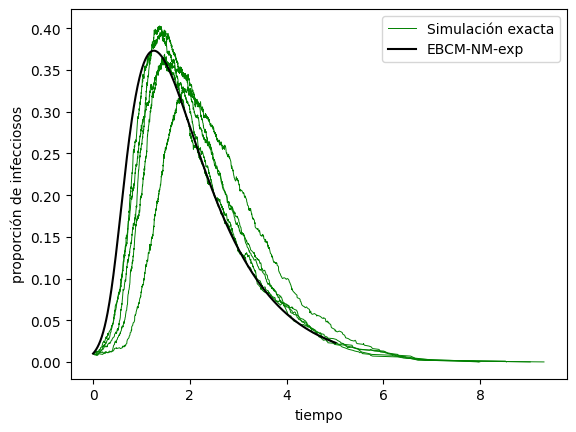

In [ ]:
#exp----------------------------------
for k in range(5):
    #------------------------------------ General
    iter_time = time.time()
    G_copy=G.copy()
    X_I_indexes_copy=X_I_indexes.copy()
    H=Gillespie_Direct_Method_Network(beta*(N-1),gamma,N,X_I_indexes=X_I_indexes_copy,G_network_initial=G_copy,T=5)
    if(k==0):
        plt.plot(H['time'],H['I(t)']/N, 'green',linewidth=0.7,label='Simulación exacta')
    else:
        plt.plot(H['time'],H['I(t)']/N, 'green',linewidth=0.7)
    print(time.time()-iter_time,' segundos por iteracion')
#exponencial Campo Medio----------------------------------

def EBCM_2(y, t, beta, gamma,psi,psi_prime):
    theta, R = y
    dydt = [-beta*theta+beta*(psi_prime(theta)/psi_prime(1))+gamma*(-theta+theta_0), gamma*(1-psi(theta)-R)]
    return dydt
from scipy.integrate import odeint
y0 = [theta_0, 0.0]
fin_T=5
t = np.linspace(0, fin_T, 1001)
sol_2 = odeint(EBCM_2, y0, t, args=(beta, gamma,approx_psi_powerlaw,approx_prime_psi_powerlaw))
def gamma_fun_exp(a):
    return gamma
T,I_exp,TH=EBCM_non_markovian(iniciales=iniciales,riesgo_inf=beta_cte,riesgo_rec=gamma_fun_exp,fgp=approx_psi_powerlaw,
                       fgp_prime_1=approx_prime_psi_powerlaw,fgp_prime_2=approx_prime_2_psi_powerlaw,step_len=step_len,fin=fin_T)
plt.ylabel('proporción de infecciosos')
plt.xlabel('tiempo')
plt.plot(T,I_exp,'black',label='EBCM-NM-exp')
####
plt.legend()
plt.savefig("EBCN_NM_sim_Exp.png",dpi=300)
plt.show()

In [ ]:
#Genera tau de siguiente reaccion de infeccion.
#Busca el siguiente tiempo de recuperacion como el mínimo de los tiempos de recuperación
#Decide cuál ocurre primero.
def Monte_Carlo_Step_exp_cte(Lambdas,dict_num_contacts,X_I_indexes,X_I_rec_times,t):
    Lambda=np.sum(Lambdas)
    tau=np.random.exponential(scale=1/Lambda)
    next_time=min(X_I_rec_times)
    index_next=X_I_rec_times.index(next_time)
    if(t+tau<next_time):#Infeccion ocurre
        u_3=np.random.uniform(0,1)
        D=0
        k=0
        while(u_3>D):
            D+=Lambdas[k]/(Lambda-Lambdas[-1])
            k+=1
        new_reaction_index=np.random.choice(range(len(dict_num_contacts[str(k-1)])))
        new_reaction=dict_num_contacts[str(k-1)][new_reaction_index]
    else:#Recuperación
        k=0
        new_reaction_index=index_next
        new_reaction=X_I_indexes[index_next]
    return tau,new_reaction,k-1,new_reaction_index
def Gillespie_Direct_Method_Network_cte(beta,gamma,N,X_I_indexes,G_network_initial=nx.Graph(),T=np.inf):
    flag=True
    #Paso 1.
    t=0 #Inicializar $t=0$.
    #Calcular $k_i$ el número de contactos infecciosos del individuo $i$.--------------------
    X_I=len(X_I_indexes)
    X_I_rec_times=[gamma for i in X_I_indexes]
    X_S=N-X_I
    Historia=[[0,X_S,X_I]]
    dict_num_contacts = {}
    for n in range(X_I+1):
        dict_num_contacts[str(n)]=[]
    num_cont_inf_por_indice=np.zeros(N)
    for i in range(N):
        if(i not in X_I_indexes): #No es infeccioso.
            count_for_i=0
            for j in X_I_indexes:
                if (G_network_initial.has_edge(i,j)):#Es un contacto Susceptible-infeccioso.
                    num_cont_inf_por_indice[i]+=1#Ya que voy a hacer los ciclos, mejor la guardo igual.
                    count_for_i+=1
            dict_num_contacts[str(count_for_i)].append(i)
    #-------------------------------------------
    while(flag):
        #Generar las Lambdas------------------
        Lambda=0
        Lambdas=[]
        for k in range(len(list(dict_num_contacts.keys()))):
            Lambdas.append((beta/N)*len(dict_num_contacts[str(k)])*k)#
            Lambda+=Lambdas[-1]
        Lambdas.append(0)###No existe recuperacion
        Lambda+=Lambdas[-1]
        #-------------------------------------------
        #Paso Monte-Carlo---------------------------
        tau,new_reaction,k_choice,new_reaction_index=Monte_Carlo_Step_exp_cte(Lambdas,dict_num_contacts,X_I_indexes,X_I_rec_times,t)
        #-------------------------------------------
        #Actualización del sistema.
        if(G_network_initial.nodes[new_reaction]['Estado:']=='Susceptible'):#Se trata de una infección
            num_cont_inf_por_indice[new_reaction]=0
            G_network_initial.nodes[new_reaction]['Estado:']='Infeccioso'#Actualizar su estado
            X_I_indexes.append(new_reaction)
            X_I_rec_times.append(t+tau+gamma)
            i=new_reaction
            dict_num_contacts[str(k_choice)].pop(new_reaction_index)#Saca al nuevo infeccioso del conjunto con exactamente k_choice contactos infecciosos.
            #Para cada nodo $j$ conectado a $i$, actualizamos su número de contactos infecciosos como $k_j=k_j+1.$--------------------
            num_max_cont=int(list(dict_num_contacts.keys())[-1])
            for vecino in G_network_initial.neighbors(i):#Para cada vecino del nuevo infectado, le aumentamos el numero de contactos en 1. (lo agregamos a la siguiente categoria y lo sacamos de la anterior)
                if (G_network_initial.nodes[vecino]['Estado:']=='Susceptible'):

                    num_cont_del_vecino=num_cont_inf_por_indice[vecino]
                    if(num_cont_del_vecino+1>num_max_cont):#Si mas de uno crea una categoria, hay error.
                        num_max_cont+=1
                        dict_num_contacts[str(int(num_cont_del_vecino+1))]=[vecino]
                    else:
                        dict_num_contacts[str(int(num_cont_del_vecino+1))].append(vecino)
                    dict_num_contacts[str(int(num_cont_del_vecino))].remove(vecino)
                    num_cont_inf_por_indice[vecino]+=1#Actualizamos ambas fuentes de informacion
            #-------------------------------------------
        else:
            G_network_initial.nodes[new_reaction]['Estado:']='Recuperado'
            num_cont_inf_por_indice[new_reaction]=0#Ya no es relevante
            X_I_indexes.pop(new_reaction_index)
            X_I_rec_times.pop(new_reaction_index)
            i=new_reaction
            #Para cada nodo $j$ conectado a $i^* $, actualizamos su número de contactos infecciosos como $k_j=k_j-1.$
            for vecino in G_network_initial.neighbors(i):#Podria ser que ya no tuviera ningun contacto
                num_cont_del_vecino=num_cont_inf_por_indice[vecino]
                if(num_cont_del_vecino!=0):# Es recuperado.
                    dict_num_contacts[str(int(num_cont_del_vecino-1))].append(vecino)
                    dict_num_contacts[str(int(num_cont_del_vecino))].remove(vecino)
                    num_cont_inf_por_indice[vecino]-=1#Actualizamos ambas fuentes de informacion
            #-------------------------------------------
        t+=tau #Actualiza el tiempo $t=t+\tau$.
        X_I=len(X_I_indexes)
        X_S=N-X_I
        Historia.append([t,X_S,X_I])#Focus
        if(X_I==0 or t>T):
            flag=False
    return pd.DataFrame(Historia,columns=['time','S(t)','I(t)'])

0.08083415031433105  segundos por iteracion
0.0699317455291748  segundos por iteracion
0.0709683895111084  segundos por iteracion
0.11143636703491211  segundos por iteracion
0.09165000915527344  segundos por iteracion


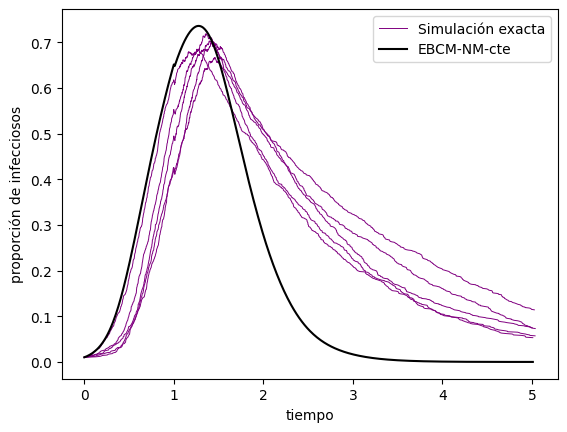

In [ ]:
#constante----------------------------------
mu=1
sigma=0.75
beta=0.75
np.random.seed(0)
def psi_survival_infection(x):
    return np.exp(-beta*x)
def psi_survival_recovery(x):
    if(x<1-0.01):
      return 1
    else:
      return 0
def psi_infection(x):
    return beta*np.exp(-beta*x)
def psi_recovery(x):
    if(abs(x-1)<0.001):
      return 1
    else:
      return 0
for k in range(5):
    #------------------------------------
    iter_time = time.time()
    G_copy=G.copy()
    X_I_indexes_copy=X_I_indexes.copy()
    H=Gillespie_Direct_Method_Network_cte(beta*(N-1),gamma=1,N=10**3,X_I_indexes=X_I_indexes_copy,G_network_initial=G_copy,T=5)
    if(k==0):
        plt.plot(H['time'],H['I(t)']/N, 'purple',linewidth=0.7,label='Simulación exacta')
    else:
        plt.plot(H['time'],H['I(t)']/N, 'purple',linewidth=0.7)
    print(time.time()-iter_time,' segundos por iteracion')
#constante Campo Medio
def gamma_fun_cte(a):
    if a==1.0:
        return 0.01**(-1)
    else:
        return 0
T,I_cte,TH=EBCM_non_markovian(iniciales=iniciales,riesgo_inf=beta_cte,riesgo_rec=gamma_fun_cte,fgp=approx_psi_powerlaw,
                       fgp_prime_1=approx_prime_psi_powerlaw,fgp_prime_2=approx_prime_2_psi_powerlaw,step_len=step_len,fin=fin_T)
plt.ylabel('proporción de infecciosos')
plt.xlabel('tiempo')
plt.plot(T,I_cte,'black',label='EBCM-NM-cte')
####
plt.legend()
plt.savefig("EBCN_NM_sim_Cte.png",dpi=300)
plt.show()